We train a model defined as
$$ B =\phi_X(A, g(X)) = \frac{A}{\gamma + n_1 g(X)^{n1}} + n_2 g(X)^{n2}, \quad A \approx 1 - \pi_Y(X), \quad \pi_y(X) \approx {\rm Prob}(Y=y|X), \quad g(X) \approx {\rm E}_{A|X}(A)$$
by minimizing the size of the intervals.
The localization function is a model for the conditional expectation of $A$.

In [74]:
import numpy
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
import matplotlib.colors as mcolors

#####################################
numpy.random.seed(12345)
EPSLR= .1
EPS = .001
alpha = .05
colors = []
for key, value in mcolors.TABLEAU_COLORS.items():
    colors.append(value)
print(colors)
######################################

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [81]:
#load and random-split the data
digits = load_digits()
X = digits.images
y = digits.target
X = X.reshape([len(X), 64])

#random
choice = numpy.random.choice(len(X), size=len(X), replace=False)
X = X[choice]
y = y[choice]
print('|all data|=', len(choice))

#split
t = 5
n = [i * int(len(X)/t) for i in range(t + 1)]
train, val1, val2, cal, test = [[X[n[i] : n[i + 1]], y[n[i] : n[i + 1]]]  for i in range(t)]
print('|train|, # of attributes = ', train[0].shape)
print('|Y| = ', max(train[1])+1)


|all data|= 1797
|train|, # of attributes =  (359, 64)
|Y| =  10


(359, 64) (359,) (359,)


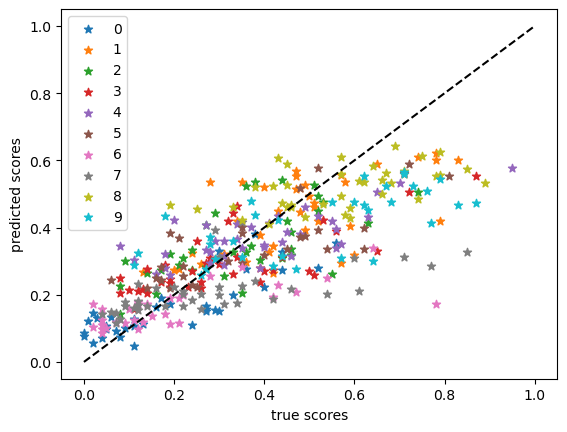

In [82]:
def classifier(D):
    X, Y = D
    rf = RandomForestClassifier(max_depth=20, random_state=0)
    rf.fit(X, Y.squeeze())
    return rf    

def approximator(D):
    X, A, Y = D
    print(X.shape, A.shape, Y.shape)
    rf = []
    for m in range(max(Y) + 1): 
        rf.append(RandomForestRegressor(max_depth=25, random_state=0))
        x = numpy.array([X[i] for i in range(len(Y)) if Y[i] == m])
        a = numpy.array([A[i] for i in range(len(Y)) if Y[i] == m])
        rf[-1].fit(x, a.squeeze())
    return rf    

#train the classifier on the training set
dataset = train
rfClass = classifier([dataset[0], dataset[1]])
dataset = test
allprobs = rfClass.predict_proba(dataset[0])
probs = numpy.array([1 - allprobs[i, dataset[1][i]].squeeze() for i in range(len(allprobs))])

#train the approximator on the first validation set
dataset = val1
allprobs = rfClass.predict_proba(dataset[0])
probs = numpy.array([1 - allprobs[i, dataset[1][i]].squeeze() for i in range(len(allprobs))])
rg = approximator([dataset[0], probs, dataset[1]])

#visualize the approximator perfomance on the test set
dataset = cal
allprobs = rfClass.predict_proba(dataset[0])
probs = numpy.array([1 - allprobs[i, dataset[1][i]].squeeze() for i in range(len(allprobs))])
probspredict = [rg[i].predict(dataset[0]) for i in range(len(rg))]

Y = dataset[1]
for m in range(len(rg)):
    p = numpy.array([probs[i] for i in range(len(Y)) if Y[i]==m])
    ppred = numpy.array([probspredict[m][i] for i in range(len(Y)) if Y[i]==m])
    plt.scatter(p, ppred, marker='*', c=colors[m], label=str(m))
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('true scores')
plt.ylabel('predicted scores')
plt.legend()
plt.show()


In [85]:
def prepareData(dataset):
    x = dataset[0]
    y = dataset[1]
    allprobs = rfClass.predict_proba(x)
    allas = 1 - allprobs
    a = numpy.array([1 - allprobs[i, y[i]].squeeze() for i in range(len(allprobs))])
    allg = [rg[i].predict(x) for i in range(max(y) + 1)]
    g = numpy.array([allg[y[i]][i].squeeze() for i in range(len(allprobs))])
    return x, a, g, allas, numpy.array(allg).transpose(), y

#prepare data for training B
valdata1 = prepareData(val1)
valdata2 = prepareData(val2)
caldata = prepareData(cal)
testdata = prepareData(test)

In [86]:
def gridOptimizer(data, rangen, M = 10, eps = EPSLR, alpha = 0.05):    
    x, a, g, allas, allg, y = data 
    vval = [data[i][:int(len(x)/2)] for i in range(len(data))]
    vtest = [data[i][int(len(x)/2):] for i in range(len(data))]

    best = evaluateCPclass(vval, vtest, [0, 0], EPSLR)[0]
    bestn = 0, 0
    tryn = numpy.linspace(rangen[0], rangen[1], num=M)
    for i in range(M):
        for j in range(M):
            n1 = tryn[i]
            n2 = tryn[j]
            sizes, val, sets = evaluateCPclass(vval, vtest, [n1, n2], EPSLR)
            if sizes < best:
                best, bestn = sizes, [n1, n2]  
    sizes0, val0, sets = evaluateCPclass(vval, vtest, [0, 0], EPSLR)
    return sizes0, best, bestn

def quantile(v, alpha):
    m = int(numpy.ceil((1 - alpha) * (len(v) + 1))) - 1
    v = numpy.sort(v, axis = 0)
    return v[m]

def B(a, g, n, eps):
    if n[0] == 0:
        return a + n[1] * numpy.power(g, n[1])
    else:
        return a/(eps + n[0] * numpy.power(g, n[0])) + n[1] * numpy.power(g, n[1])

def evaluateCPclass(caldata, testdata, n, EPSLR, alpha = .05):
    x, a, g, allas, allg, y = caldata 
    b = [[B(allas[i][m], allg[i][m], n, EPSLR) for m in range(max(y) + 1)] for i in range(len(allas))]
    q = quantile([b[i][y[i]] for i in range(len(y))], alpha)
    
    x, a, g, allas, allg, y = testdata
    b = [[B(allas[i][m], allg[i][m], n, EPSLR) for m in range(max(y) + 1)] for i in range(len(allas))]
    sets = [[m for m in range(max(y) + 1) if b[i][m] < q] for i in range(len(y))]
    sizes = numpy.sum([len(sets[i]) for i in range(len(sets))])/len(y)
    val = numpy.sum([1 for i in range(len(y)) if y[i] in sets[i]])/len(y)
    return sizes, val, sets

def F1score(caldata, testdata, n, EPSLR, alpha = .05):
    sizes, val, sets = evaluateCPclass(caldata, testdata, n, EPSLR, alpha = .05)
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(sets)):
        interval = sets[i]
        positives = [j for j in range(10) if j in interval]
        TP = TP + sum([1 for j in positives if j == y[i]])
        FP = FP + sum([1 for j in positives if j != y[i]])
        negatives = [j for j in range(10) if j not in interval]
        TN = TN + sum([1 for j in negatives if j != y[i]])  
        FN = FN + sum([1 for j in negatives if j == y[i]]) 
    F1 = 2 * TP/(2 * TP + FP + FN)
    return sizes, val, F1


In [87]:
#grid train n1 and n2 on the second validation data set and test on the calibration and test data sets
ns, vsizes, sizes, vals, F1s = [], [], [], [], []
R = 10
for iN in range(R):
    rangen = [-(iN + 1)/R, (iN + 1)/R]
    r0, r, bestn = gridOptimizer(valdata2, rangen) 
    scores = [F1score(caldata, testdata, [0, 0], EPSLR), 
              F1score(caldata, testdata, bestn, EPSLR)]
    vsizes.append([r0, r])
    ns.append(bestn)         
    sizes.append([s[0] for s in scores])
    vals.append([s[1] for s in scores])
    F1s.append([s[2] for s in scores])
    
    print('nbest', bestn)
    print('vsizes', vsizes[-1])
    print('sizes', sizes[-1])
    print('vals', vals[-1])
    print('F1s', F1s[-1])


nbest [-0.07777777777777778, -0.1]
vsizes [1.0722222222222222, 0.95]
sizes [1.064066852367688, 1.0557103064066853]
vals [0.9610027855153204, 0.9498607242339833]
F1s [0.11605937921727395, 0.10840108401084012]
nbest [0.15555555555555556, -0.06666666666666668]
vsizes [1.0722222222222222, 1.0333333333333334]
sizes [1.064066852367688, 1.052924791086351]
vals [0.9610027855153204, 0.9610027855153204]
F1s [0.11605937921727395, 0.1112618724559023]
nbest [0.3, -0.09999999999999998]
vsizes [1.0722222222222222, 1.0]
sizes [1.064066852367688, 1.0250696378830084]
vals [0.9610027855153204, 0.9526462395543176]
F1s [0.11605937921727395, 0.11279229711141678]
nbest [0.4, -0.13333333333333336]
vsizes [1.0722222222222222, 0.9666666666666667]
sizes [1.064066852367688, 1.0139275766016713]
vals [0.9610027855153204, 0.9498607242339833]
F1s [0.11605937921727395, 0.11065006915629322]
nbest [0.5, -0.16666666666666669]
vsizes [1.0722222222222222, 0.9555555555555556]
sizes [1.064066852367688, 1.0194986072423398]
va

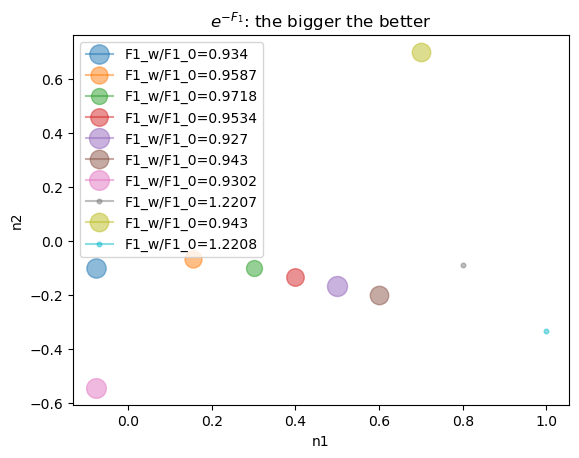

In [98]:
#visualize the best n1 and n2
vsizes = numpy.array(vsizes)
vsizes = vsizes/numpy.max(vsizes)
sizes = numpy.array(sizes)
sizes = sizes/numpy.max(sizes)
vals = numpy.array(vals)
vals = vals/numpy.max(vals)

names = ['a', 'b']
markers = ['*b', '*r']

scores = [F1s[iN][1]/F1s[iN][0] for iN in range(len(ns))]
for iN in range(len(ns)):
    n1, n2 = ns[iN]
    score = scores[iN]
    plt.plot(n1, n2, marker='o', markersize= 10 * numpy.exp(5 -5 * score), alpha=.5, label='F1_w/F1_0='+str(numpy.round(score, 4)))
plt.ylabel('n2')
plt.xlabel('n1')
plt.title('$e^{-F_1}$: the bigger the better')
plt.legend()
plt.show()
#